In [102]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [103]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 20
# batch size for training
batch_size = 32
# height and width of input image
img_size = 64
# number of channels
nc0 = 1
nc1 = 4
nc2 = 8
nc3 = 16
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 1e-4

In [104]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [105]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path1 = os.path.join(self.root_dir, "R/", f"{idx}.npy")
        img_path2 = os.path.join(self.root_dir, "B/", f"{idx}.npy")

        img1 = np.load(img_path1)
        img2 = np.load(img_path2)

        img1 = img1[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
        img2 = img2[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        sample = {'c1': img1, 'c2': img2}

        return sample

In [111]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=1)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [117]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv1same = nn.Conv2d(nc1, nc1, 3, padding=1)
        self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
        self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
        self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
        self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

        self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
        self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
        self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

        self.batchnorm0 = nn.BatchNorm2d(nc0)
        self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc1)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv2back(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        
        x = self.conv1back(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        
        return x

In [118]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            
            # 8 x img_size/4 x img_size/4
            nn.Conv2d(nc2, nc3, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc3),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 16 x img_size/8 x img_size/8
            nn.Flatten(),
            nn.Linear(nc3 * img_size // 8 * img_size // 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [119]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
    encdec.load_state_dict(torch.load('encdec.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        
        for it in range(num_dis):
            for i, data in enumerate(dataloader):
                disc.zero_grad()
                
                b_size = data['c2'].size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                
                outputD = disc(data['c2']).view(-1)
                lossD_real = criterionD(outputD, label)
                lossD_real.backward()

                # all fake batch
                outputED = encdec(data['c1'])
                label.fill_(fake_label)
                outputD = disc(outputED.detach()).view(-1)
                lossD_fake = criterionD(outputD, label)
                lossD_fake.backward()

                lossD = lossD_real + lossD_fake
                optimizerD.step()

        for i, data in enumerate(dataloader):
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = data['c2'].size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(data['c2']).view(-1)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data['c1'])
            
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach()).view(-1)
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED).view(-1)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, data['c2'])
            outputED_norm = (outputED + 1) / 2
            datac2_norm = (data['c2'] + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, datac2_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            if i % 50 == 49:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}")
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['c1'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                plt.show()
    
    torch.save(encdec.state_dict(), 'encdec.pt')
    print("Done")

Epoch 1, Iteration 50, Loss D 8.844197164755315, Loss Disc 349.42638540267944, Loss L1 4.891385063529015


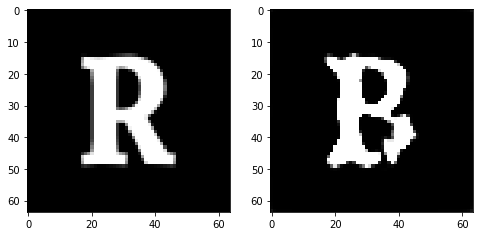

Epoch 1, Iteration 100, Loss D 1.4633303388254717, Loss Disc 493.08396100997925, Loss L1 4.374823480844498


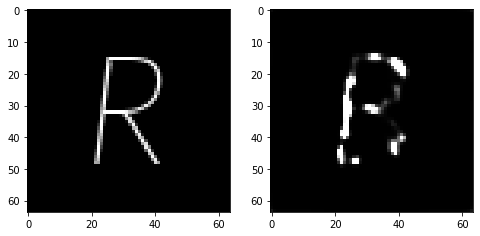

Epoch 2, Iteration 50, Loss D 0.05035902224972233, Loss Disc 815.7401437759399, Loss L1 4.347032532095909


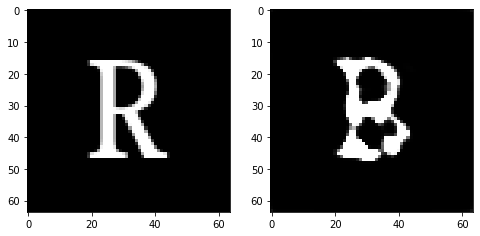

Epoch 2, Iteration 100, Loss D 0.030932746818052692, Loss Disc 823.6125717163086, Loss L1 4.375239253044128


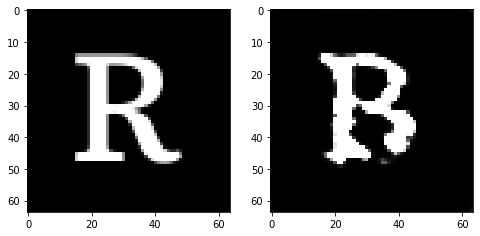

Epoch 3, Iteration 50, Loss D 0.006668146211836756, Loss Disc 858.0894403457642, Loss L1 4.300805181264877


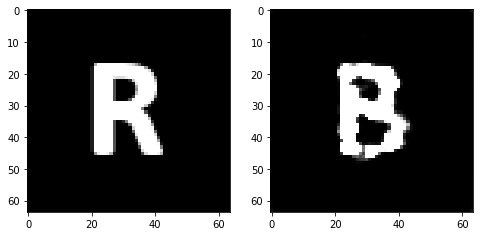

Epoch 3, Iteration 100, Loss D 0.00692192705122352, Loss Disc 908.0442171096802, Loss L1 4.4124017134308815


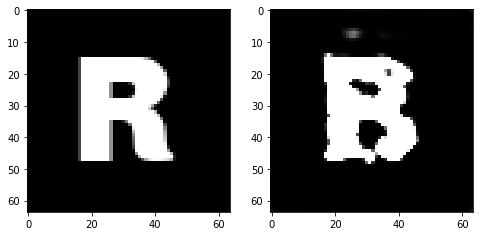

Epoch 4, Iteration 50, Loss D 0.0042217430497828445, Loss Disc 954.0841178894043, Loss L1 4.343032702803612


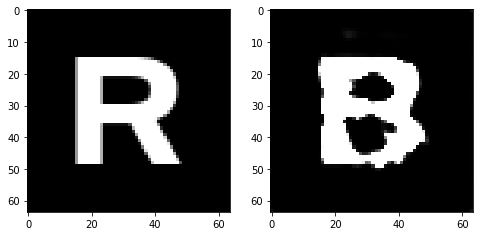

Epoch 4, Iteration 100, Loss D 0.003424861207832919, Loss Disc 903.4265594482422, Loss L1 4.260038062930107


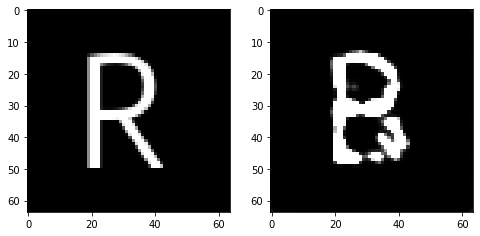

Epoch 5, Iteration 50, Loss D 0.0022857295207927564, Loss Disc 868.5309782028198, Loss L1 4.254288785159588


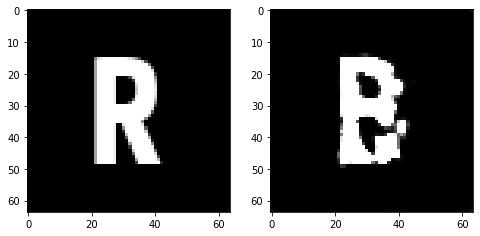

Epoch 5, Iteration 100, Loss D 0.004937529956464459, Loss Disc 870.8161630630493, Loss L1 4.32300541549921


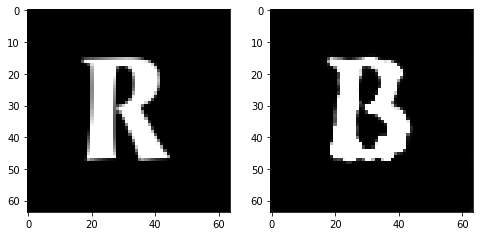

Epoch 6, Iteration 50, Loss D 23.599239556118846, Loss Disc 169.89124462008476, Loss L1 4.71800472587347


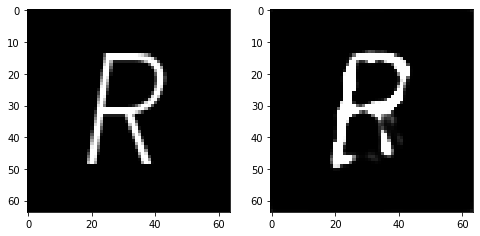

Epoch 6, Iteration 100, Loss D 9.734454528661445, Loss Disc 278.61728362739086, Loss L1 4.238540276885033


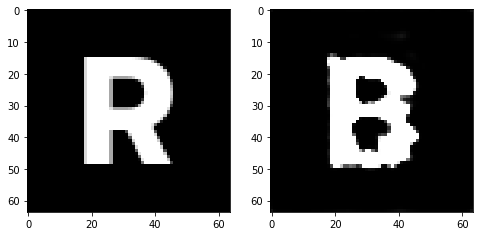

Epoch 7, Iteration 50, Loss D 6.837258116807789, Loss Disc 188.6588568687439, Loss L1 4.1772181168198586


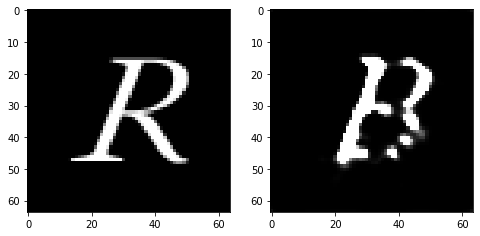

Epoch 7, Iteration 100, Loss D 0.4312441040528938, Loss Disc 305.9758024215698, Loss L1 4.236585579812527


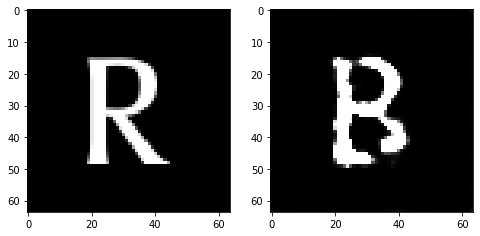

Epoch 8, Iteration 50, Loss D 1.5372973456978798, Loss Disc 195.59434485435486, Loss L1 4.241309933364391


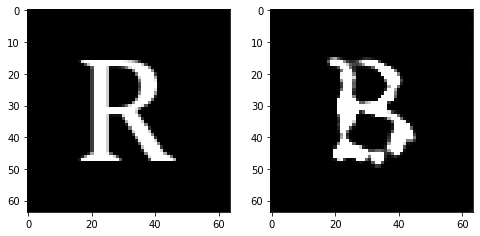

Epoch 8, Iteration 100, Loss D 0.22717893635854125, Loss Disc 291.9812002182007, Loss L1 4.134963735938072


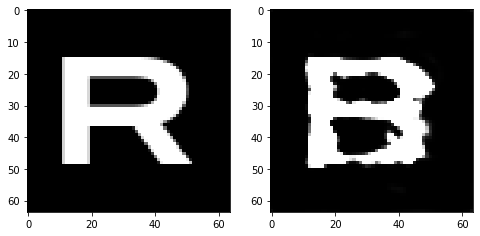

Epoch 9, Iteration 50, Loss D 34.99533933773637, Loss Disc 93.66056051850319, Loss L1 4.190858505666256


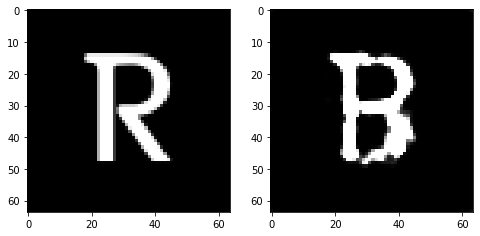

Epoch 9, Iteration 100, Loss D 1.8514785119332373, Loss Disc 271.2128393650055, Loss L1 4.132862135767937


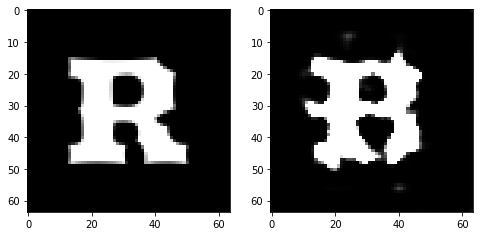

Epoch 10, Iteration 50, Loss D 6.160443291417323, Loss Disc 238.03254806995392, Loss L1 4.180935963988304


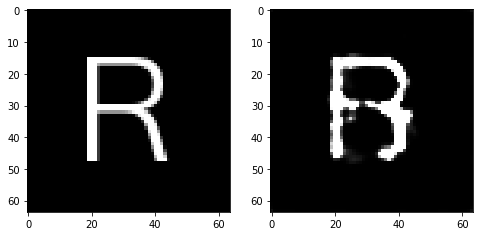

Epoch 10, Iteration 100, Loss D 0.322160113719292, Loss Disc 336.78232622146606, Loss L1 4.2080656215548515


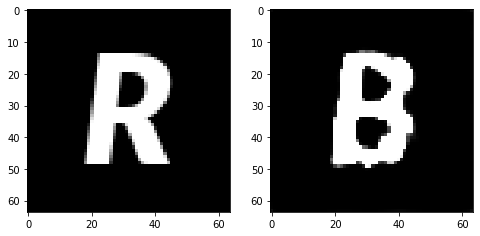

Epoch 11, Iteration 50, Loss D 9.302029675338417, Loss Disc 183.727681517601, Loss L1 4.547426097095013


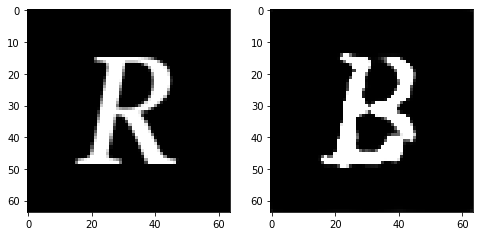

Epoch 11, Iteration 100, Loss D 5.71407086472027, Loss Disc 275.5093923807144, Loss L1 4.1459445133805275


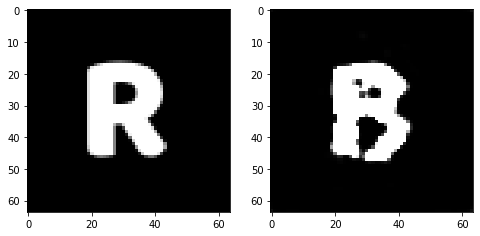

Epoch 12, Iteration 50, Loss D 1.5888896696269512, Loss Disc 199.33379805088043, Loss L1 4.102311111986637


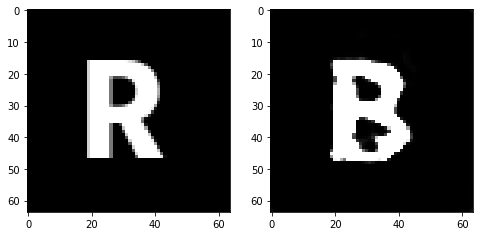

Epoch 12, Iteration 100, Loss D 0.3051154220011085, Loss Disc 287.6403160095215, Loss L1 4.073734484612942


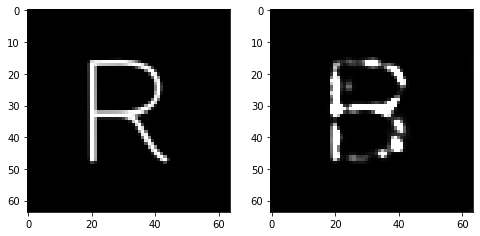

Epoch 13, Iteration 50, Loss D 2.7390388534404337, Loss Disc 196.13159823417664, Loss L1 4.108533725142479


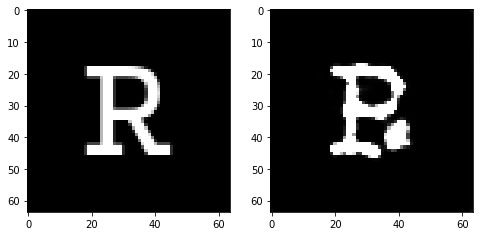

Epoch 13, Iteration 100, Loss D 2.50652525620535, Loss Disc 269.6157443523407, Loss L1 4.0331907868385315


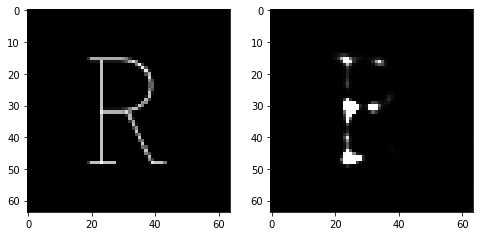

Epoch 14, Iteration 50, Loss D 0.6963870096951723, Loss Disc 234.27185654640198, Loss L1 4.0200343653559685


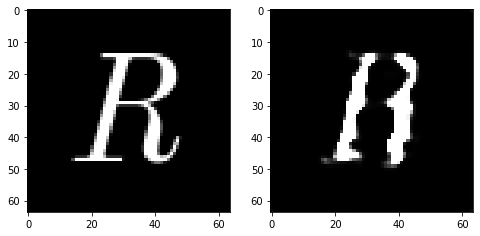

Epoch 14, Iteration 100, Loss D 1.541778092738241, Loss Disc 282.3011591434479, Loss L1 4.05878759175539


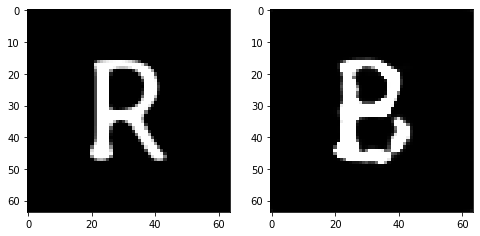

Epoch 15, Iteration 50, Loss D 2.502613718621433, Loss Disc 211.49434852600098, Loss L1 4.021492250263691


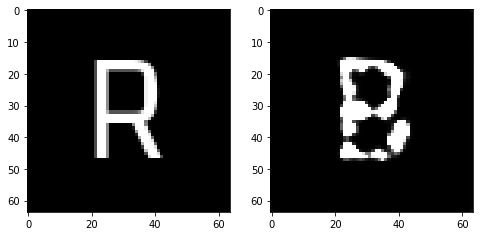

Epoch 15, Iteration 100, Loss D 0.799099832540378, Loss Disc 319.5188834667206, Loss L1 4.013392902910709


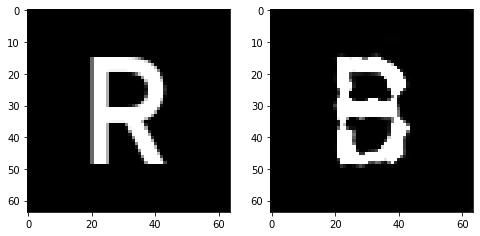

Epoch 16, Iteration 50, Loss D 6.089313411037438, Loss Disc 272.81042420864105, Loss L1 3.990199714899063


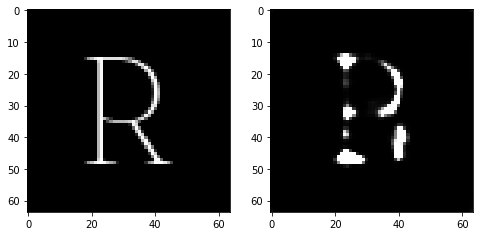

Epoch 16, Iteration 100, Loss D 0.7280978331109509, Loss Disc 326.99974489212036, Loss L1 3.9799342080950737


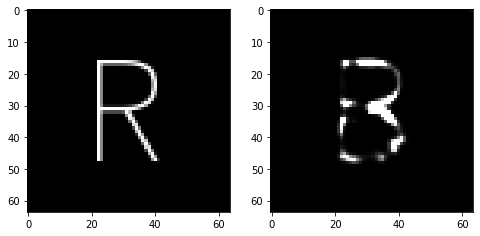

Epoch 17, Iteration 50, Loss D 0.023153336907853372, Loss Disc 452.96456384658813, Loss L1 3.961784243583679


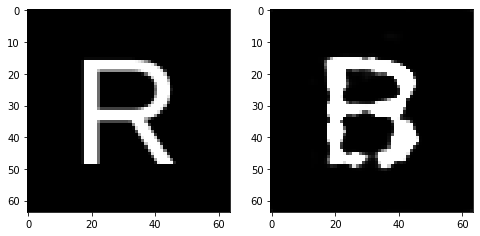

Epoch 17, Iteration 100, Loss D 0.16107084659597604, Loss Disc 448.82760858535767, Loss L1 3.9477843567728996


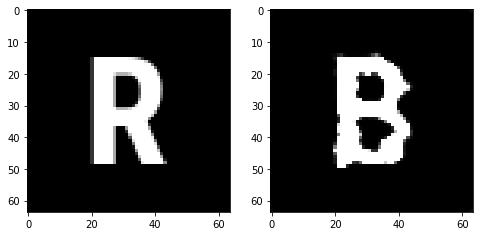

Epoch 18, Iteration 50, Loss D 1.7822628176072612, Loss Disc 285.201220035553, Loss L1 3.9129106029868126


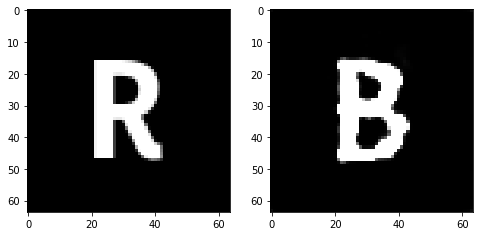

Epoch 18, Iteration 100, Loss D 0.2198958219087217, Loss Disc 425.3335771560669, Loss L1 3.9439159855246544


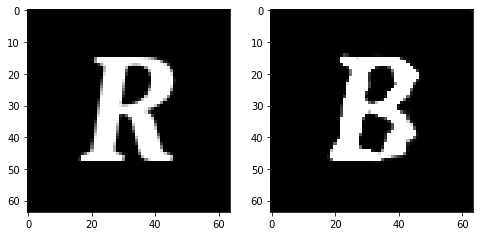

Epoch 19, Iteration 50, Loss D 2.911492618964985, Loss Disc 238.3490710258484, Loss L1 3.9812253266572952


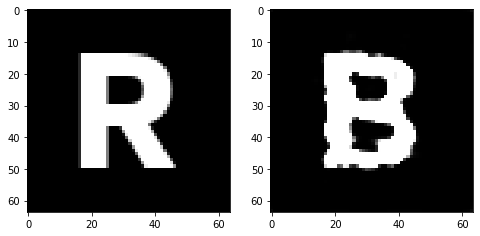

Epoch 19, Iteration 100, Loss D 0.4979273028438911, Loss Disc 391.479190826416, Loss L1 3.8811276108026505


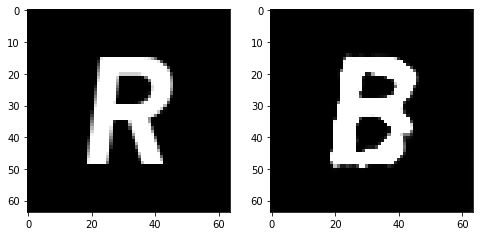

Epoch 20, Iteration 50, Loss D 0.034035554286674596, Loss Disc 602.3917112350464, Loss L1 3.8676955699920654


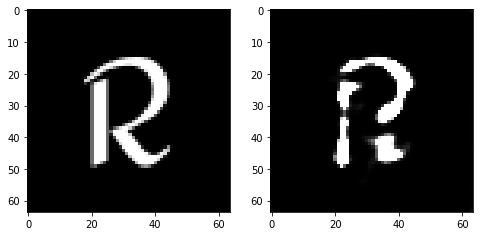

Epoch 20, Iteration 100, Loss D 0.029034425628196914, Loss Disc 624.1944580078125, Loss L1 3.950648009777069


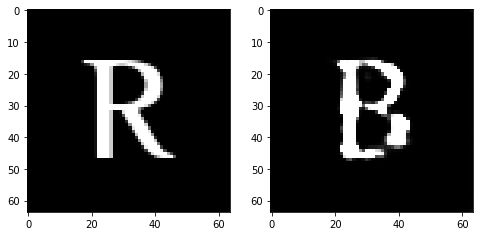

Done


In [120]:
main()

In [ ]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [91]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec.pt'))
encdec.eval()

EncoderDecoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1same): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2back): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1back): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1strided): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2strided): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1strided): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2strided): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(

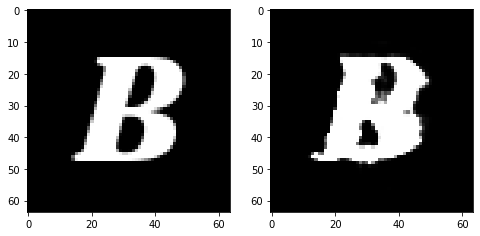

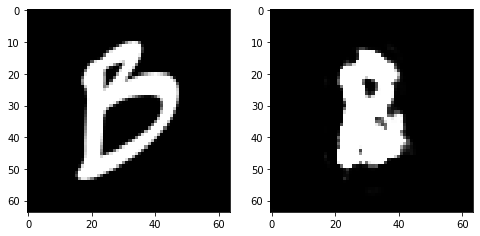

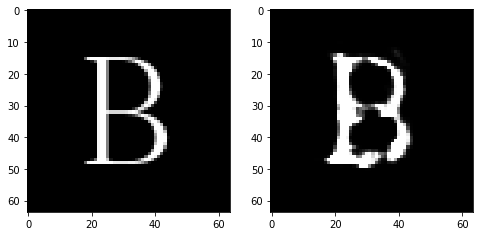

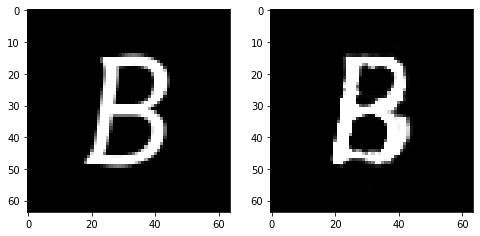

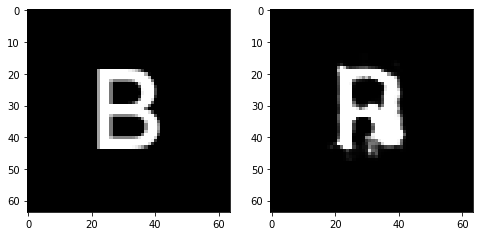

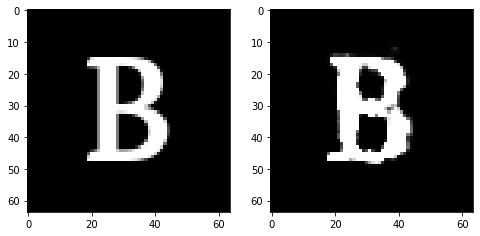

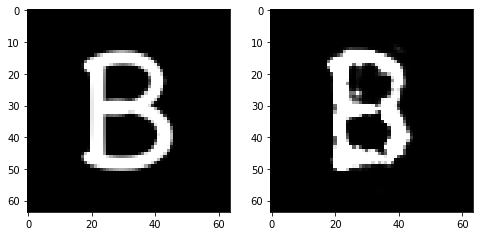

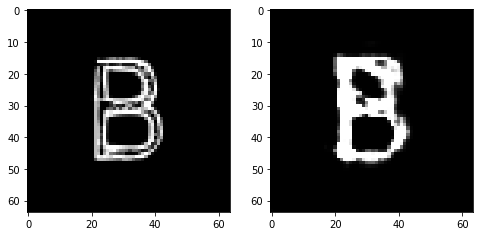

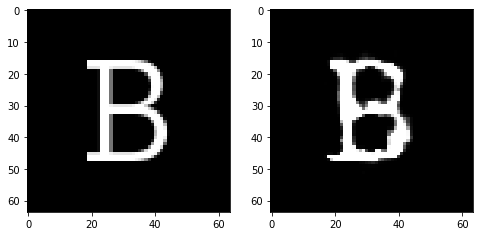

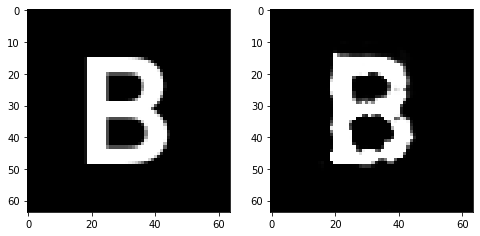

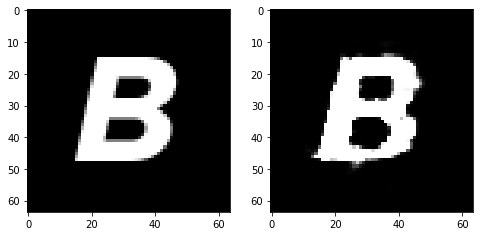

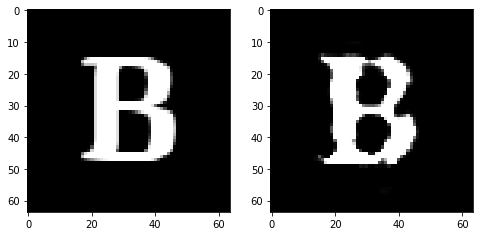

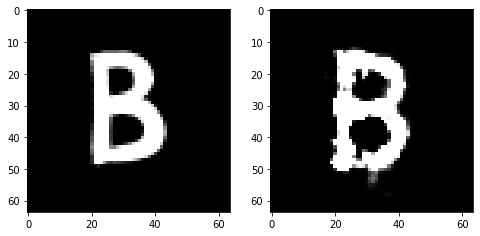

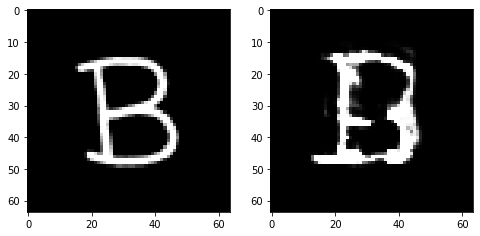

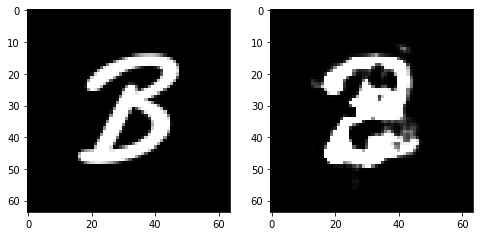

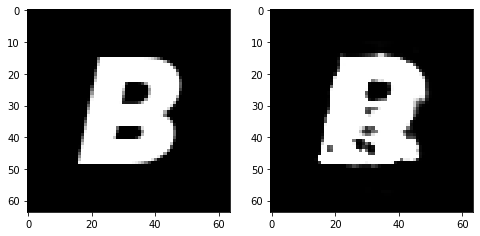

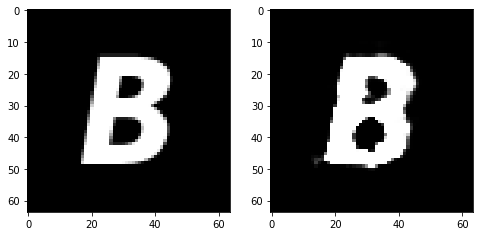

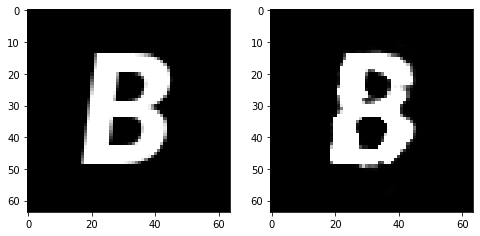

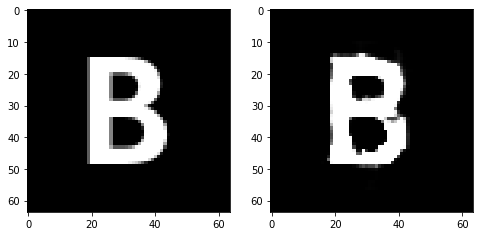

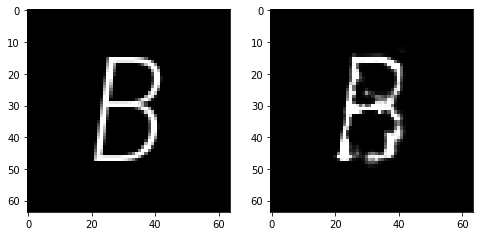

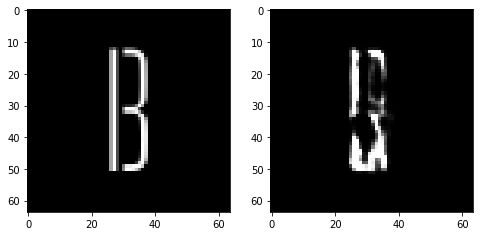

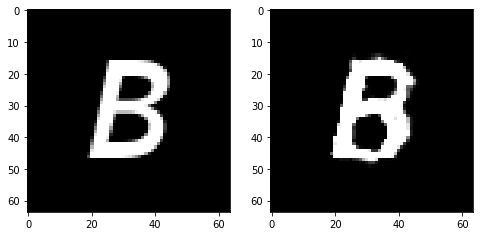

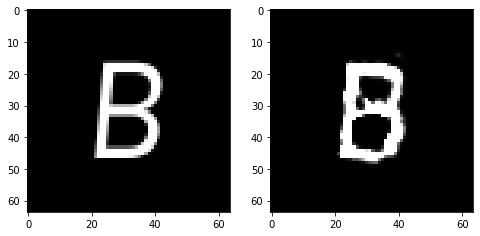

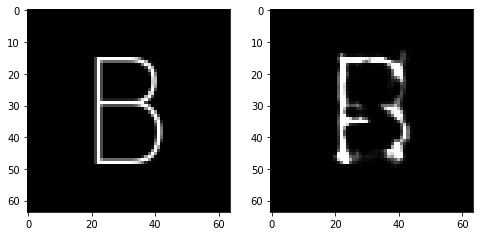

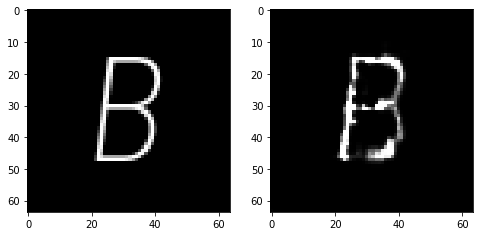

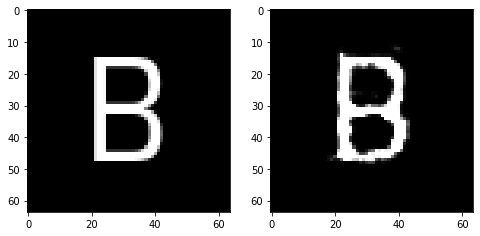

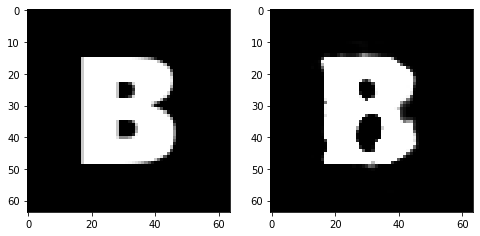

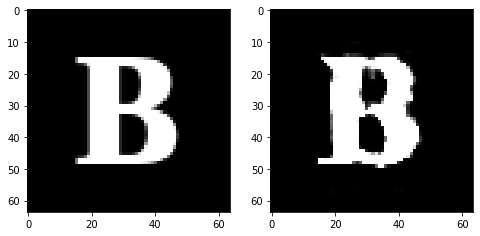

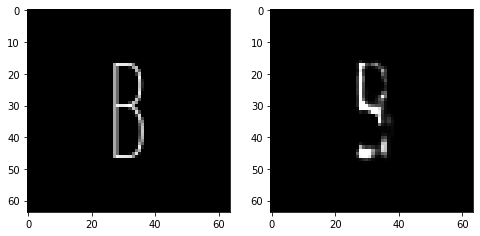

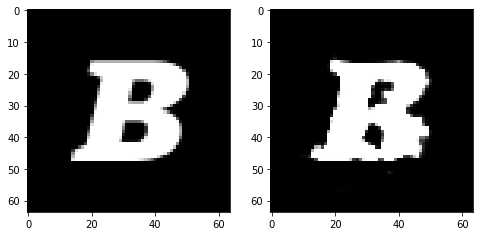

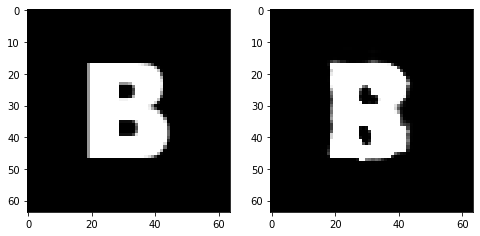

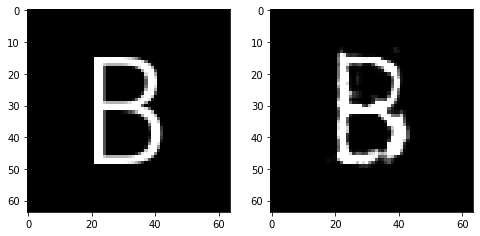

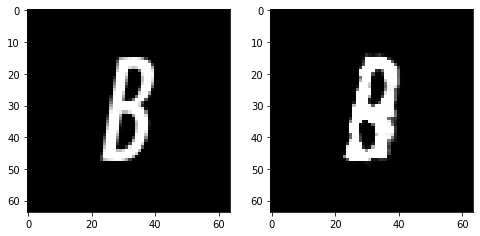

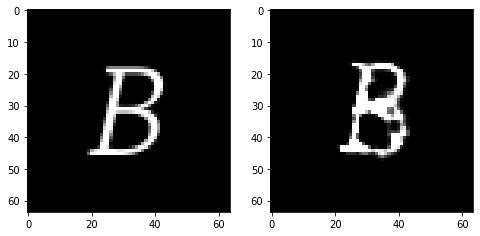

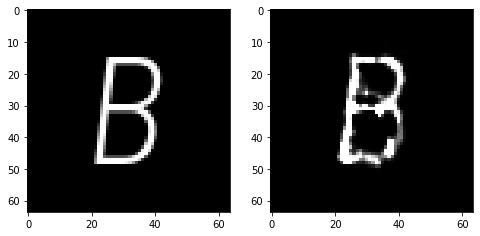

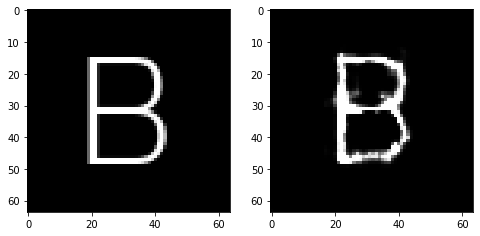

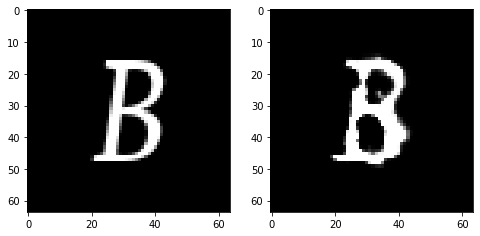

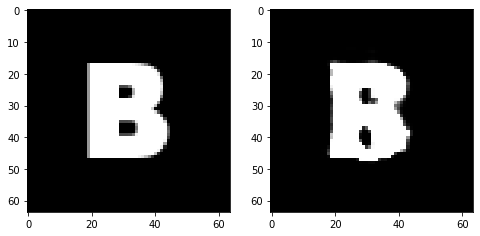

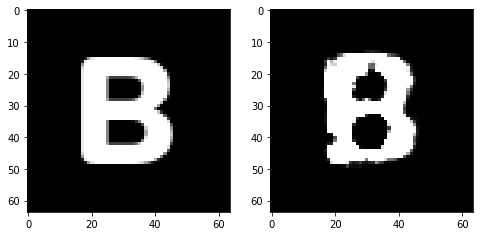

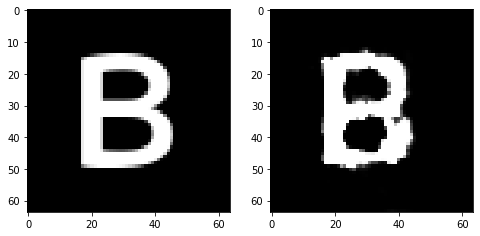

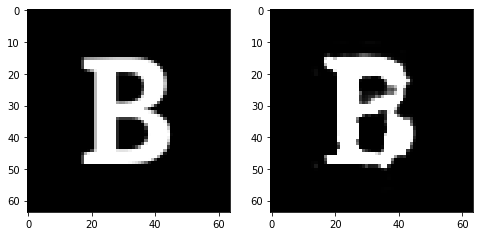

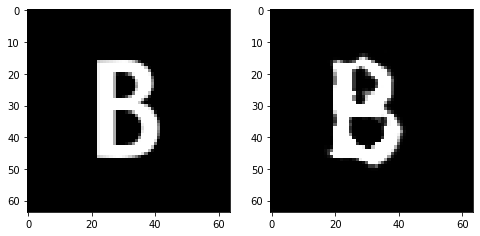

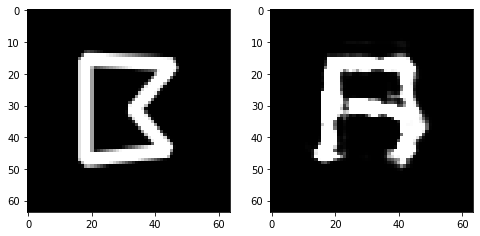

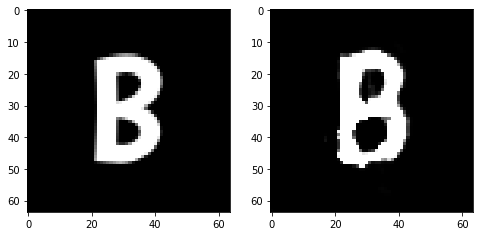

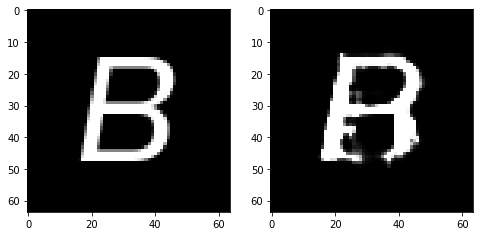

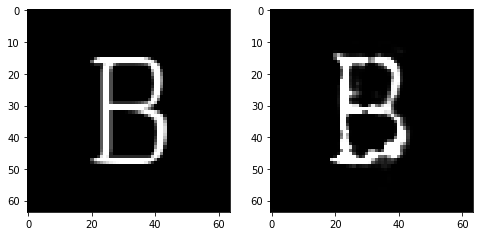

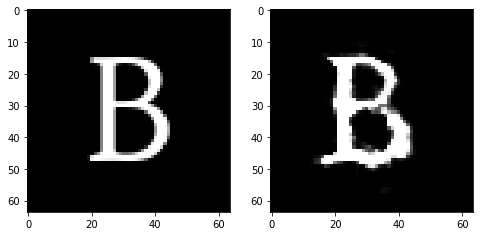

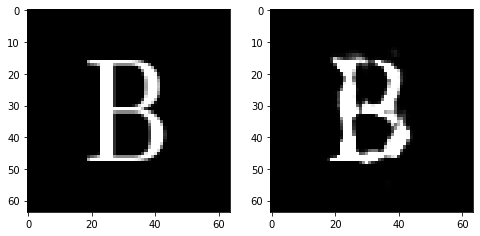

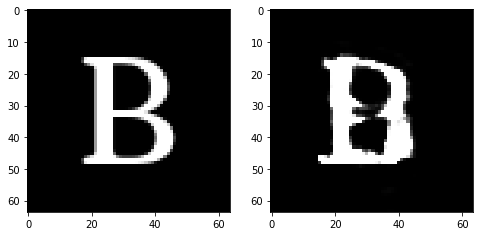

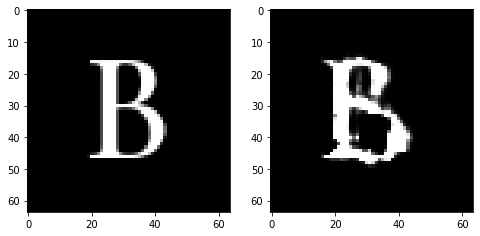

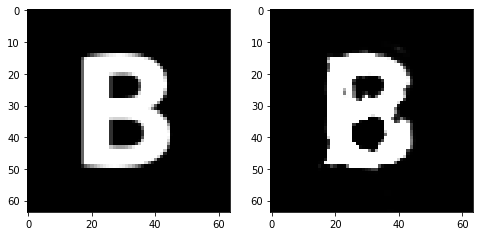

In [121]:
for i, data in enumerate(dataloader):
    if i > 50:
        break
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['c1'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.show()

In [26]:
font_set = pd.read_csv('fonts.csv', sep=' ', header=None)

letter_dir = './images/B'
for file in os.listdir(letter_dir):
    print(file)
    img = np.load(os.path.join(letter_dir, file))
    
    num = int(file.split('.')[0])
    font_name = font_set[1][num]
    print(font_name)
    
    plt.imshow(img, cmap='gray')
    plt.show()